# Ring-Down Data Analysis

This notebook analyzes real ring-down measurement data using two frequency estimation methods:

1. **Nonlinear Least Squares (NLS)** with ring-down model

2. **DFT Peak Fitting with Lorentzian Function**

The data files are located in the `data/` folder and include both CSV and MAT files.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.optimize import least_squares, curve_fit
from scipy.signal import detrend
from scipy.signal.windows import kaiser
import os
import glob
from pathlib import Path

# Set up plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10


## Frequency Estimation Methods

In [2]:
def _lorentzian_func(f: np.ndarray, A: float, f0: float, gamma: float, offset: float) -> np.ndarray:
    """
    Lorentzian function for power spectrum fitting.
    
    P(f) = A / ((f - f0)^2 + (gamma/2)^2) + offset
    """
    return A / ((f - f0)**2 + (gamma / 2.0)**2) + offset


def _estimate_gamma_from_half_max(P: np.ndarray, k: int, fs: float, N_dft: int) -> float:
    """
    Estimate gamma (FWHM) from half-maximum points in power spectrum.
    
    Returns:
        Estimated gamma value in Hz
    """
    P_max = P[k]
    half_max = P_max / 2.0
    
    # Find left half-maximum point
    left_idx = k
    for i in range(k - 1, max(0, k - 10), -1):
        if P[i] < half_max:
            left_idx = i
            break
    
    # Find right half-maximum point
    right_idx = k
    for i in range(k + 1, min(len(P), k + 10)):
        if P[i] < half_max:
            right_idx = i
            break
    
    if right_idx > left_idx:
        return (right_idx - left_idx) * fs / N_dft
    else:
        return 2.0 * fs / N_dft


def _fit_lorentzian_to_peak(
    P: np.ndarray,
    k: int,
    fs: float,
    N_dft: int,
    n_points: int = 7,
) -> float:
    """
    Fit a Lorentzian function to the power spectrum around the peak.
    
    For ring-down signals, the Fourier transform has a Lorentzian shape,
    so fitting a Lorentzian is more appropriate than, e.g., parabolic interpolation.
    """
    # Determine range of bins to use
    half_range = n_points // 2
    k_start = max(0, k - half_range)
    k_end = min(len(P), k + half_range + 1)
    
    # Extract frequency and power values
    k_indices = np.arange(k_start, k_end)
    f_bins = k_indices * fs / N_dft
    P_bins = P[k_indices]
    
    # Initial parameter guesses
    P_max = P[k]
    f0_init = k * fs / N_dft
    gamma_init = _estimate_gamma_from_half_max(P, k, fs, N_dft)
    
    # Estimate background offset from edges
    offset_init = np.min([P[0], P[-1], np.mean(P[:max(1, len(P)//20)])])
    
    # Initial amplitude guess
    A_init = P_max * (gamma_init / 2.0)**2
    
    # Fit Lorentzian
    try:
        popt, _ = curve_fit(
            _lorentzian_func,
            f_bins,
            P_bins,
            p0=[A_init, f0_init, gamma_init, offset_init],
            bounds=([
                0.0,
                f_bins[0],
                0.0,
                -np.inf,
            ], [
                np.inf,
                f_bins[-1],
                (f_bins[-1] - f_bins[0]) * 2.0,
                np.inf,
            ]),
            maxfev=1000,
        )
        
        A_fit, f0_fit, gamma_fit, offset_fit = popt
        
        # Calculate delta (offset from bin k)
        delta = (f0_fit - f0_init) / (fs / N_dft)
        
        # Clip delta to reasonable range
        delta = np.clip(delta, -0.5, 0.5)
        
        return delta
    except (RuntimeError, ValueError, np.linalg.LinAlgError):
        return 0.0


def _estimate_initial_tau_from_envelope(x: np.ndarray, t: np.ndarray) -> float:
    """
    Estimate initial tau from signal envelope decay using RMS in windows.
    
    Returns:
        Initial tau estimate in seconds
    """
    N = len(x)
    window_size = min(1000, N // 10)
    n_windows = N // window_size
    
    rms_values = []
    for i in range(n_windows):
        start = i * window_size
        end = start + window_size
        rms_values.append(np.std(x[start:end]))
    
    rms_values = np.array(rms_values)
    rms_peak = np.max(rms_values)
    decay_idx = np.where(rms_values < rms_peak * np.exp(-1))[0]
    
    if len(decay_idx) > 0 and decay_idx[0] > 0:
        return t[decay_idx[0] * window_size]
    else:
        return t[-1] / 2.0


def _estimate_initial_parameters_from_dft(x: np.ndarray, fs: float) -> tuple:
    """
    Estimate initial frequency, phase, amplitude, and DC offset from DFT.
    
    Returns:
        (f0_init, phi0_init, A0_init, c0)
    """
    N = len(x)
    X = np.fft.rfft(x * np.hanning(N))
    mag2 = np.abs(X) ** 2
    
    # Skip DC component (k=0) when finding peak
    mag2_no_dc = mag2.copy()
    mag2_no_dc[0] = 0.0
    k = int(np.argmax(mag2_no_dc))
    
    # Use Lorentzian fitting for initial guess if possible
    if k > 0 and k < len(mag2) - 1:
        delta = _fit_lorentzian_to_peak(mag2, k, fs, N, n_points=7)
        k_interp = k + delta
    else:
        k_interp = k
    
    f0_init = k_interp * fs / N
    phi0_init = np.angle(X[k])
    
    # Initial amplitude estimation with sanity check
    A0_init = np.sqrt(2.0) * np.sqrt(mag2[k] / N)
    if A0_init < 0.1 * np.std(x) or A0_init > 10 * np.std(x):
        A0_init = np.std(x) * np.sqrt(2.0)
    
    c0 = np.mean(x)
    
    return f0_init, phi0_init, A0_init, c0


def estimate_freq_nls_ringdown(x: np.ndarray, fs: float, tau_known: float = None) -> float:
    """
    Estimate frequency using nonlinear least squares with ring-down model.
    """
    N = len(x)
    t = np.arange(N) / fs
    
    # Get initial parameter estimates
    f0_init, phi0_init, A0_init, c0 = _estimate_initial_parameters_from_dft(x, fs)
    
    if tau_known is not None:
        # Known tau: estimate (A0, f, phi, c)
        def residuals(p):
            A0, f, phi, c = p
            return (A0 * np.exp(-t / tau_known) * np.cos(2.0 * np.pi * f * t + phi) + c) - x
        
        # Tighter frequency bounds
        df = fs / N
        f_low = max(0.0, f0_init - max(0.2 * f0_init, 2 * df))
        f_high = min(0.5 * fs, f0_init + max(0.2 * f0_init, 2 * df))
        
        lb = [0.0, f_low, -np.pi, -np.inf]
        ub = [10.0 * A0_init, f_high, np.pi, np.inf]
        
        res = least_squares(
            residuals,
            x0=np.array([A0_init, f0_init, phi0_init, c0]),
            bounds=(lb, ub),
            method="trf",
            ftol=1e-8,
            xtol=1e-8,
            gtol=1e-8,
            max_nfev=500,
            verbose=0,
        )
        
        if not res.success:
            return f0_init
        
        _, f_hat, _, _ = res.x
    else:
        # Unknown tau: estimate (A0, f, phi, tau, c)
        tau_init = _estimate_initial_tau_from_envelope(x, t)
        
        def residuals(p):
            A0, f, phi, tau, c = p
            return (A0 * np.exp(-t / tau) * np.cos(2.0 * np.pi * f * t + phi) + c) - x
        
        df = fs / N
        f_low = max(0.0, f0_init - max(0.2 * f0_init, 2 * df))
        f_high = min(0.5 * fs, f0_init + max(0.2 * f0_init, 2 * df))
        
        lb = [0.0, f_low, -np.pi, t[1], -np.inf]
        ub = [10.0 * A0_init, f_high, np.pi, 10.0 * t[-1], np.inf]
        
        res = least_squares(
            residuals,
            x0=np.array([A0_init, f0_init, phi0_init, tau_init, c0]),
            bounds=(lb, ub),
            method="trf",
            ftol=1e-8,
            xtol=1e-8,
            gtol=1e-8,
            max_nfev=1000,
            verbose=0,
        )
        
        if not res.success:
            return f0_init
        
        _, f_hat, _, _, _ = res.x
    
    # Sanity check
    if f_hat < 0 or f_hat > 0.5 * fs or abs(f_hat - f0_init) > 0.5 * f0_init:
        return f0_init
    
    return float(f_hat)


def estimate_freq_dft(x: np.ndarray, fs: float, window: str = "kaiser", kaiser_beta: float = 9.0) -> float:
    """
    Estimate frequency using DFT peak fitting with Lorentzian function.
    Default window is Kaiser with beta=9.0 for high side-lobe suppression.
    """
    N = len(x)
    
    # Apply window
    if window == "kaiser":
        w = kaiser(N, kaiser_beta)
    elif window == "hann":
        w = np.hanning(N)
    elif window == "rect":
        w = np.ones(N)
    elif window == "blackman":
        w = np.blackman(N)
    else:
        raise ValueError(f"Unknown window: {window}")
    
    xw = x * w
    
    # Compute one-sided DFT
    X = np.fft.rfft(xw)
    P = np.abs(X) ** 2
    
    # Find peak bin (skip DC component k=0)
    P_no_dc = P.copy()
    P_no_dc[0] = 0.0
    k = int(np.argmax(P_no_dc))
    
    # Guard against edges
    if k <= 0 or k >= len(P) - 1:
        return k * fs / N
    
    # Fit Lorentzian to power spectrum around peak
    delta = _fit_lorentzian_to_peak(P, k, fs, N, n_points=7)
    
    f_hat = (k + delta) * fs / N
    return float(f_hat)


def crlb_var_f_ringdown_explicit(A0: float, sigma: float, fs: float, N: int, tau: float) -> float:
    """
    Cramér-Rao lower bound for frequency estimation variance with ring-down,
    calculated from explicit Fisher information matrix.
    """
    Ts = 1.0 / fs
    t = np.arange(N) * Ts
    
    exp_factor = np.exp(-2.0 * t / tau)
    S_0 = np.sum(exp_factor)
    S_1 = np.sum(t * exp_factor)
    S_2 = np.sum(t**2 * exp_factor)
    
    I_eff_omega = (A0**2 / sigma**2) * (S_2 - S_1**2 / S_0)
    
    if I_eff_omega < 1e-30:
        return np.inf
    
    crlb_var_f = 1.0 / ((2.0 * np.pi) ** 2 * I_eff_omega)
    
    return crlb_var_f


In [3]:
## Helper Functions for Data Processing

def estimate_tau_from_full_data(data: np.ndarray, t: np.ndarray, fs: float) -> float:
    """
    Estimate tau from full data using NLS fit.
    
    Returns:
        Estimated tau value in seconds
    """
    N = len(data)
    t_norm = t - t[0]
    
    # Get initial parameter estimates
    f0_init, phi0_init, A0_init, c0 = _estimate_initial_parameters_from_dft(data, fs)
    
    # Initial tau guess from envelope decay
    tau_init = _estimate_initial_tau_from_envelope(data, t_norm)
    
    # NLS fit to estimate tau: fit (A0, f, phi, tau, c)
    def residuals_tau(p):
        A0, f, phi, tau, c = p
        return (A0 * np.exp(-t_norm / tau) * np.cos(2.0 * np.pi * f * t_norm + phi) + c) - data
    
    df = fs / N
    f_low = max(0.0, f0_init - max(0.2 * f0_init, 2 * df))
    f_high = min(0.5 * fs, f0_init + max(0.2 * f0_init, 2 * df))
    
    lb = [0.0, f_low, -np.pi, t_norm[1], -np.inf]
    ub = [10.0 * A0_init, f_high, np.pi, 10.0 * t_norm[-1], np.inf]
    
    res_tau = least_squares(
        residuals_tau,
        x0=np.array([A0_init, f0_init, phi0_init, tau_init, c0]),
        bounds=(lb, ub),
        method="trf",
        ftol=1e-8,
        xtol=1e-8,
        gtol=1e-8,
        max_nfev=1000,
        verbose=0,
    )
    
    if res_tau.success:
        _, _, _, tau_est, _ = res_tau.x
        # Sanity check
        if tau_est <= 0 or not np.isfinite(tau_est) or tau_est > 10.0 * t_norm[-1] or tau_est < t_norm[1]:
            return tau_init
        return tau_est
    else:
        return tau_init


def estimate_noise_parameters(data_cropped: np.ndarray, t_crop: np.ndarray, tau_est: float, fs: float) -> tuple:
    """
    Estimate A0 (initial amplitude) and sigma (noise std) from cropped data.
    
    Returns:
        (A0_est, sigma_est)
    """
    N_crop = len(data_cropped)
    t_crop_norm = t_crop - t_crop[0]
    
    # Initial estimate from first portion
    n_init = min(1000, N_crop // 10)
    A0_est = np.sqrt(2.0) * np.std(data_cropped[:n_init])
    
    # Fit model to get residuals for noise estimation
    def model_residuals(p):
        A0, f, phi, c = p
        return (A0 * np.exp(-t_crop_norm / tau_est) * np.cos(2.0 * np.pi * f * t_crop_norm + phi) + c) - data_cropped
    
    # Get initial guesses
    f0_init, phi0_init, A0_init, c0 = _estimate_initial_parameters_from_dft(data_cropped, fs)
    
    # Quick fit to get residuals
    df = fs / N_crop
    f_low = max(0.0, f0_init - max(0.2 * f0_init, 2 * df))
    f_high = min(0.5 * fs, f0_init + max(0.2 * f0_init, 2 * df))
    
    res_fit = least_squares(
        model_residuals,
        x0=np.array([A0_init, f0_init, phi0_init, c0]),
        bounds=([0.0, f_low, -np.pi, -np.inf], [10.0 * A0_init, f_high, np.pi, np.inf]),
        method="trf",
        ftol=1e-6,
        max_nfev=200,
        verbose=0,
    )
    
    if res_fit.success:
        residuals = res_fit.fun
        sigma_est = np.std(residuals)
        A0_est = res_fit.x[0]
    else:
        # Fallback: estimate noise from tail
        tail_start = max(int(0.8 * len(data_cropped)), len(data_cropped) - 1000)
        sigma_est = np.std(data_cropped[tail_start:])
    
    return A0_est, sigma_est


def crop_data_to_tau(t: np.ndarray, data: np.ndarray, tau_est: float, min_samples: int = 100) -> tuple:
    """
    Crop data to 3*tau_est to avoid long noisy tail affecting frequency estimation.
    
    Parameters:
    -----------
    t : np.ndarray
        Time array
    data : np.ndarray
        Signal array
    tau_est : float
        Estimated tau value in seconds
    min_samples : int
        Minimum number of samples required. If cropped data is shorter, return original.
    
    Returns:
    --------
    (t_crop, data_cropped) - cropped time and signal arrays
    """
    t_crop_max = 3.0 * tau_est
    crop_idx = t <= t_crop_max
    t_crop = t[crop_idx]
    data_cropped = data[crop_idx]
    
    # If cropped data is too short, return original
    if len(t_crop) < min_samples:
        return t.copy(), data.copy()
    
    return t_crop, data_cropped


def process_data_file(filepath: str, file_type: str) -> dict:
    """
    Process a single data file (CSV or MAT) and return analysis results.
    
    Parameters:
    -----------
    filepath : str
        Path to the data file
    file_type : str
        'CSV' or 'MAT'

    Returns:
    --------
    dict
        Results dictionary with all analysis data
    """
    # Load data
    if file_type == 'CSV':
        t, data = load_csv_data(filepath)
        V2 = None
    else:  # MAT
        t, data, V2 = load_mat_data(filepath)
    
    # Calculate sampling frequency
    fs = 1.0 / np.mean(np.diff(t))
    
    # Estimate tau from full data
    tau_est = estimate_tau_from_full_data(data, t, fs)
    
    # Crop data to 3*tau_est to avoid long noisy tail affecting frequency estimation
    t_crop, data_cropped = crop_data_to_tau(t, data, tau_est, min_samples=1000)
    
    # Warn if cropped data is too short for reliable frequency estimation
    # (crop_data_to_tau already handles very short data by returning original)
    min_samples_for_analysis = 1000  # Reasonable minimum for frequency estimation
    if len(t_crop) < min_samples_for_analysis:
        print(f"  Warning: Cropped data too short ({len(t_crop)} samples < {min_samples_for_analysis}), using original")
        t_crop = t
        data_cropped = data
    
    # Estimate frequencies on cropped data
    f_nls = estimate_freq_nls_ringdown(data_cropped, fs)
    f_dft = estimate_freq_dft(data_cropped, fs, window='kaiser')
    
    # Estimate noise parameters
    A0_est, sigma_est = estimate_noise_parameters(data_cropped, t_crop, tau_est, fs)
    
    # Calculate CRLB
    N_crop = len(data_cropped)
    crlb_var_f = crlb_var_f_ringdown_explicit(A0_est, sigma_est, fs, N_crop, tau_est)
    crlb_std_f = np.sqrt(crlb_var_f) if np.isfinite(crlb_var_f) else np.inf
    
    return {
        'filename': Path(filepath).name,
        'type': file_type,
        't': t,
        'data': data,
        'V2': V2,
        't_crop': t_crop,
        'data_cropped': data_cropped,
        'fs': fs,
        'tau_est': tau_est,
        'f_nls': f_nls,
        'f_dft': f_dft,
        'A0_est': A0_est,
        'sigma_est': sigma_est,
        'crlb_std_f': crlb_std_f,
        'N': len(t),
        'N_crop': len(t_crop),
        'T': t[-1],
        'T_crop': t_crop[-1] if len(t_crop) > 0 else 0
    }


## Data Loading

We need to:

- For CSV files: Load column 1 (time) and column 4 (phase in cycles)

- For MAT files: Load `moku.data[:, 1]` (time) and `moku.data[:, 4]` (phase in cycles)

- Detrend the phase data


In [4]:
def _is_data_line(line: str) -> bool:
    """Check if a line contains numeric data (not a header or comment)."""
    if not line or line.startswith('%'):
        return False
    
    parts = line.split(',')
    if len(parts) < 4:
        return False
    
    try:
        float(parts[0])  # First column should be numeric
        return True
    except ValueError:
        return False


def load_csv_data(filepath):
    """
    Load CSV data file from Moku:Lab Phasemeter.
    
    Returns:
        t: time array (s), starting from 0
        data: phase in cycles (detrended)
    """
    # Read the file, skipping comment lines and headers
    data_lines = []
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if _is_data_line(line):
                data_lines.append(line)
    
    # Parse data
    data_list = []
    for line in data_lines:
        parts = [float(x.strip()) for x in line.split(',')]
        data_list.append(parts)
    
    data_array = np.array(data_list)
    
    # Extract time (column 1, index 0) and phase (column 4, index 3)
    t_raw = data_array[:, 0]
    data_raw = data_array[:, 3]  # Column 4 is index 3
    
    # Time starts from 0
    t = t_raw - t_raw[0]
    
    # Detrend phase data
    data = detrend(data_raw, type='constant')
    
    return t, data


def load_mat_data(filepath):
    """
    Load MAT data file from Moku:Lab Phasemeter.
    
    Returns:
        t: time array (s), starting from 0
        data: phase in cycles (detrended)
        V2: phase in cycles (detrended) or None if not available
    """
    mat_data = loadmat(filepath)
    
    # Access the moku.data structure
    moku_data = mat_data['moku']['data'][0, 0]
    
    # Extract time (column 1, index 0) and phase (column 4, index 3)
    t_raw = moku_data[:, 0].flatten()
    data_raw = moku_data[:, 3].flatten()  # Column 4 is index 3
    
    # Check if V2 exists (column 9, index 8)
    V2 = None
    if moku_data.shape[1] > 8:
        V2_raw = moku_data[:, 8].flatten()  # Column 9 is index 8
        V2 = detrend(V2_raw, type='constant')
    
    # Time starts from 0
    t = t_raw - t_raw[0]
    
    # Detrend phase data
    data = detrend(data_raw, type='constant')
    
    return t, data, V2


## Find All Data Files


In [5]:
data_dir = Path('data')
csv_files = sorted(glob.glob(str(data_dir / '*.csv')))
mat_files = sorted(glob.glob(str(data_dir / '*.mat')))

print(f"Found {len(csv_files)} CSV files and {len(mat_files)} MAT files")
print("\nCSV files:")
for f in csv_files:
    print(f"  - {Path(f).name}")
print("\nMAT files:")
for f in mat_files:
    print(f"  - {Path(f).name}")


Found 3 CSV files and 11 MAT files

CSV files:
  - MTS_ringdown_050_laser_out_Test1_20250828_014146_5e-5to1e-5mbar.csv
  - MTS_ringdown_050_laser_out_Test2_20250828_234506 1.csv
  - MTS_ringdown_050_laser_out_Test5_20250901_224711_1.5e-6mbar.csv

MAT files:
  - MTSRingdownEighthAttempt_20250904_111201.mat
  - MTSRingdownEleventhAttempt_20250907_165500.mat
  - MTSRingdownFifthAttempt_20250828_132020 1.mat
  - MTSRingdownFirstAttempt_20250826_163810 1.mat
  - MTSRingdownFourthAttempt_20250828_110040 1.mat
  - MTSRingdownNinthAttempt_20250905_094849.mat
  - MTSRingdownSeventhAttempt_20250903_122800.mat
  - MTSRingdownSixthAttempt_20250902_143723.mat
  - MTSRingdownTenthAttempt_20250906_151021.mat
  - MTSRingdownThirdAttempt_20250827_112458 1.mat
  - MTSRingdownTwelfthAttempt_20250908_171953.mat


## Analyze Each Data File

For each file, we'll:

1. Load the data

2. Calculate sampling frequency

3. Estimate tau from envelope decay

4. Crop data to $3 \cdot \tau$ to avoid long noisy tail affecting frequency estimation

5. Estimate frequency using both NLS and DFT methods on cropped data

6. Estimate A0 (initial amplitude) and sigma (noise std) for CRLB calculation

7. Calculate the CRLB (Cramér-Rao Lower Bound) for frequency estimation

8. Store results for comparison


In [6]:
results = []

# Process CSV files (use tau_known=True)
for csv_file in csv_files:
    try:
        print(f"\nProcessing {Path(csv_file).name}...")
        r = process_data_file(csv_file, 'CSV')
        results.append(r)
        
        print(f"  Sampling frequency: {r['fs']:.2f} Hz")
        print(f"  Estimated tau: {r['tau_est']:.2f} s")
        print(f"  Cropped to: {r['T_crop']:.2f} s ({r['N_crop']} samples, {r['N_crop']/r['N']*100:.1f}% of original)")
        print(f"  NLS frequency: {r['f_nls']:.6f} Hz")
        print(f"  DFT frequency: {r['f_dft']:.6f} Hz")
        print(f"  Difference: {abs(r['f_nls'] - r['f_dft']):.6e} Hz")
        print(f"  CRLB std: {r['crlb_std_f']:.6e} Hz")
    except Exception as e:
        print(f"  Error processing {Path(csv_file).name}: {e}")
        import traceback
        traceback.print_exc()

# Process MAT files (use tau_known=False)
for mat_file in mat_files:
    try:
        print(f"\nProcessing {Path(mat_file).name}...")
        r = process_data_file(mat_file, 'MAT')
        # Add fs_crop field for MAT files (for backward compatibility)
        r['fs_crop'] = r['fs']
        results.append(r)
        
        print(f"  Sampling frequency: {r['fs']:.2f} Hz")
        print(f"  Estimated tau: {r['tau_est']:.2f} s")
        print(f"  Cropped to: {r['T_crop']:.2f} s ({r['N_crop']} samples, {r['N_crop']/r['N']*100:.1f}% of original)")
        print(f"  NLS frequency: {r['f_nls']:.6f} Hz")
        print(f"  DFT frequency: {r['f_dft']:.6f} Hz")
        print(f"  Difference: {abs(r['f_nls'] - r['f_dft']):.6e} Hz")
        print(f"  CRLB std: {r['crlb_std_f']:.6e} Hz")
    except Exception as e:
        print(f"  Error processing {Path(mat_file).name}: {e}")
        import traceback
        traceback.print_exc()

print(f"\n\nSuccessfully processed {len(results)} files")



Processing MTS_ringdown_050_laser_out_Test1_20250828_014146_5e-5to1e-5mbar.csv...
  Sampling frequency: 476.84 Hz
  Estimated tau: 16711.90 s
  Cropped to: 43200.00 s (20599366 samples, 100.0% of original)
  NLS frequency: 7.199717 Hz
  DFT frequency: 7.199723 Hz
  Difference: 5.893480e-06 Hz
  CRLB std: 1.472448e-09 Hz

Processing MTS_ringdown_050_laser_out_Test2_20250828_234506 1.csv...
  Sampling frequency: 119.21 Hz
  Estimated tau: 11294.26 s
  Cropped to: 33882.79 s (4039144 samples, 78.4% of original)
  NLS frequency: 7.199840 Hz
  DFT frequency: 7.199819 Hz
  Difference: 2.078257e-05 Hz
  CRLB std: 5.683674e-09 Hz

Processing MTS_ringdown_050_laser_out_Test5_20250901_224711_1.5e-6mbar.csv...
  Sampling frequency: 119.21 Hz
  Estimated tau: 6812.69 s
  Cropped to: 20438.05 s (2436407 samples, 47.3% of original)
  NLS frequency: 7.199706 Hz
  DFT frequency: 7.199753 Hz
  Difference: 4.692060e-05 Hz
  CRLB std: 1.668195e-08 Hz

Processing MTSRingdownEighthAttempt_20250904_111201.

## Summary Table

Create a summary table comparing the results from both methods.


In [19]:
import pandas as pd

# Create summary dataframe
summary_data = []
for r in results:
    summary_data.append({
        'Filename': r['filename'],
        'Type': r['type'],
        'N (samples)': r['N'],
        'N_crop (samples)': r['N_crop'],
        'T (s)': f"{r['T']:.2f}",
        'T_crop (s)': f"{r['T_crop']:.2f}",
        'fs (Hz)': f"{r['fs']:.2f}",
        'tau_est (s)': f"{r['tau_est']:.2f}",
        'f_NLS (Hz)': f"{r['f_nls']:.6f}",
        'f_DFT (Hz)': f"{r['f_dft']:.6f}",
        '|f_NLS - f_DFT| (Hz)': f"{abs(r['f_nls'] - r['f_dft']):.6e}",
        'CRLB std (Hz)': f"{r['crlb_std_f']:.6e}",
        'A0_est': f"{r['A0_est']:.4f}",
        'sigma_est': f"{r['sigma_est']:.6e}",
    })

df_summary = pd.DataFrame(summary_data)
print("Summary of Frequency Estimation Results:")
print("=" * 120)
print(df_summary.to_string(index=False))


Summary of Frequency Estimation Results:
                                                           Filename Type  N (samples)  N_crop (samples)    T (s) T_crop (s) fs (Hz) tau_est (s) f_NLS (Hz) f_DFT (Hz) |f_NLS - f_DFT| (Hz) CRLB std (Hz)    A0_est    sigma_est
MTS_ringdown_050_laser_out_Test1_20250828_014146_5e-5to1e-5mbar.csv  CSV     20599366          20599366 43200.00   43200.00  476.84    16711.90   7.199717   7.199723         5.893480e-06  1.472448e-09  583.3340 8.257399e+01
             MTS_ringdown_050_laser_out_Test2_20250828_234506 1.csv  CSV      5149842           4039144 43200.00   33882.79  119.21    11294.26   7.199840   7.199819         2.078257e-05  5.683674e-09  254.5969 4.014371e+01
    MTS_ringdown_050_laser_out_Test5_20250901_224711_1.5e-6mbar.csv  CSV      5149842           2436407 43200.00   20438.05  119.21     6812.69   7.199706   7.199753         4.692060e-05  1.668195e-08  553.8576 1.200801e+02
                       MTSRingdownEighthAttempt_20250904_111201

## Visualize Results

Plot the time series data and frequency estimates for each file.


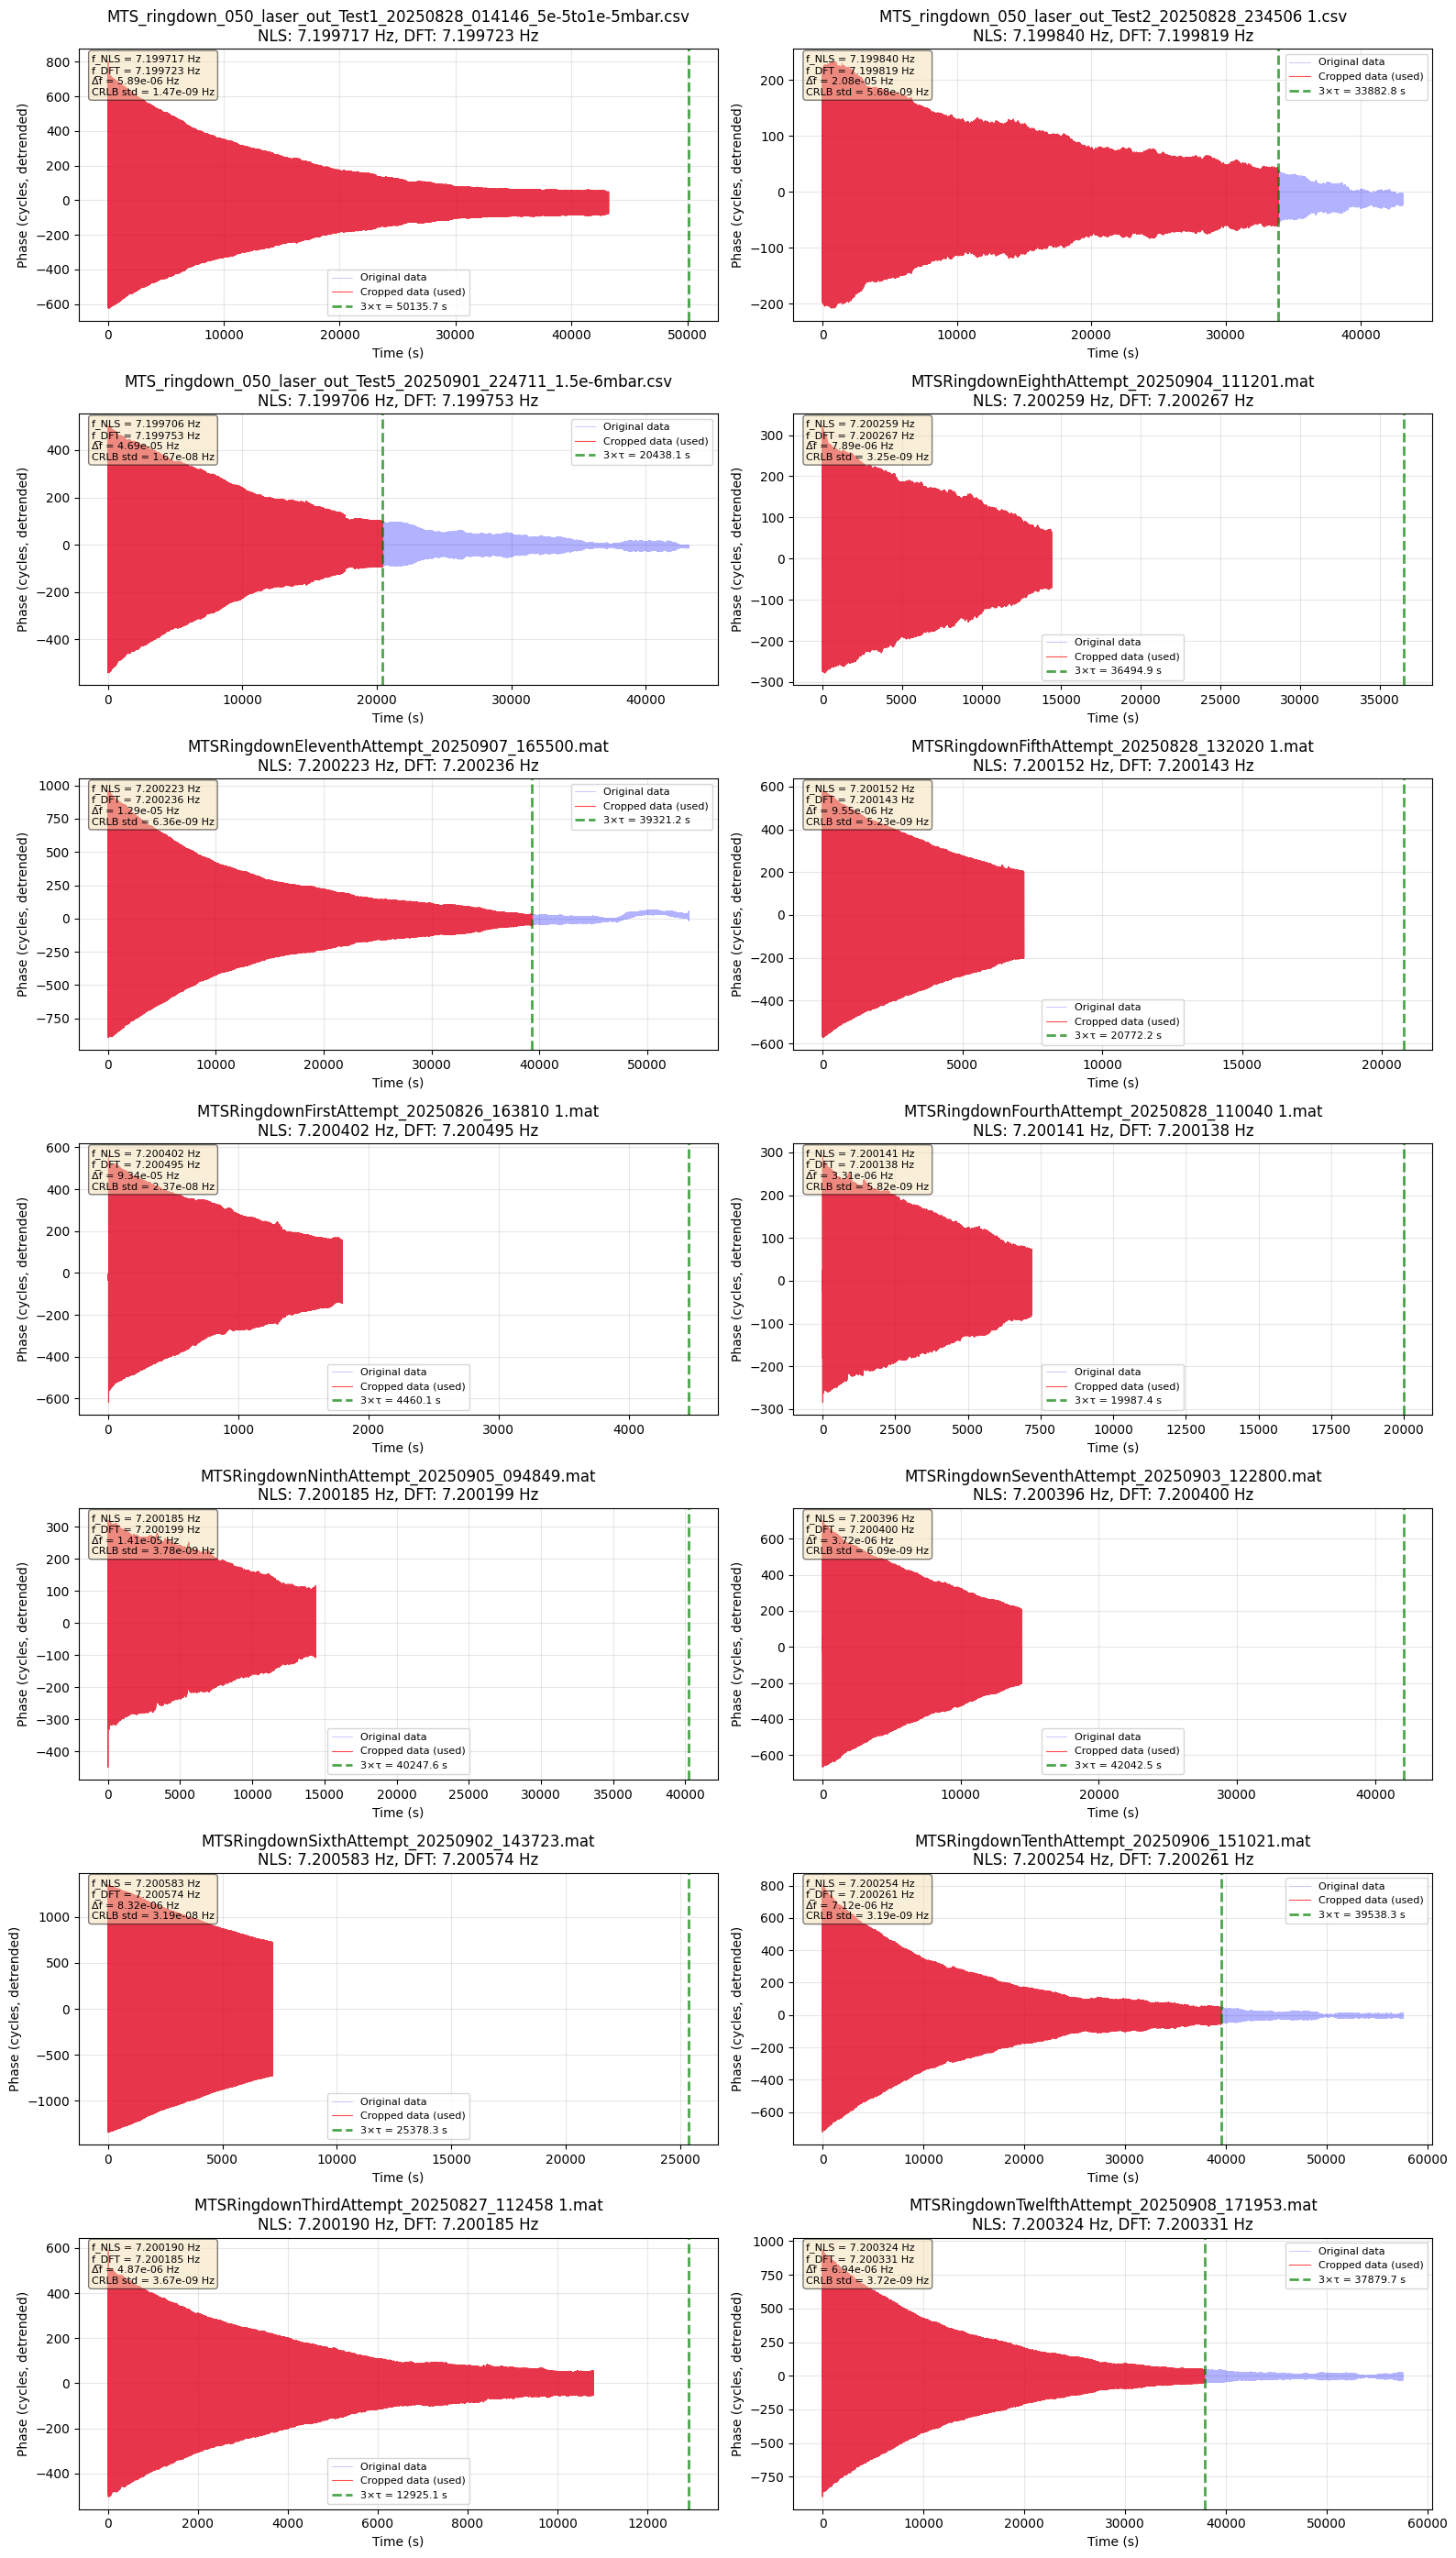

In [8]:
# Plot all results
n_files = len(results)
n_cols = 2
n_rows = (n_files + 1) // 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
if n_files == 1:
    axes = [axes]
else:
    axes = axes.flatten()

for idx, r in enumerate(results):
    ax = axes[idx]
    
    # Plot time series (original)
    t_plot = r['t']
    data_plot = r['data']
    
    # Downsample for plotting if too many points
    if len(t_plot) > 100000:
        step = len(t_plot) // 100000
        t_plot = t_plot[::step]
        data_plot = data_plot[::step]
    
    ax.plot(t_plot, data_plot, 'b-', alpha=0.3, linewidth=0.5, label='Original data')
    
    # Plot cropped data (highlighted)
    t_crop_plot = r['t_crop']
    data_cropped_plot = r['data_cropped']
    
    if len(t_crop_plot) > 100000:
        step = len(t_crop_plot) // 100000
        t_crop_plot = t_crop_plot[::step]
        data_cropped_plot = data_cropped_plot[::step]
    
    ax.plot(t_crop_plot, data_cropped_plot, 'r-', alpha=0.7, linewidth=0.8, label='Cropped data (used)')
    
    # Add vertical line at 3*tau_est
    t_crop_max = 3.0 * r['tau_est']
    ax.axvline(t_crop_max, color='g', linestyle='--', linewidth=2, alpha=0.7, label=f'3×τ = {t_crop_max:.1f} s')
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Phase (cycles, detrended)')
    ax.set_title(f"{r['filename']}\nNLS: {r['f_nls']:.6f} Hz, DFT: {r['f_dft']:.6f} Hz")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
    
    # Add frequency estimates and CRLB as text
    textstr = (f"f_NLS = {r['f_nls']:.6f} Hz\n"
               f"f_DFT = {r['f_dft']:.6f} Hz\n"
               f"Δf = {abs(r['f_nls'] - r['f_dft']):.2e} Hz\n"
               f"CRLB std = {r['crlb_std_f']:.2e} Hz")
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            fontsize=8)

# Hide unused subplots
for idx in range(n_files, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


## Q Factor Analysis

Calculate and plot the quality factor $Q$ for each measurement, where $Q = \pi f_0 \tau$.


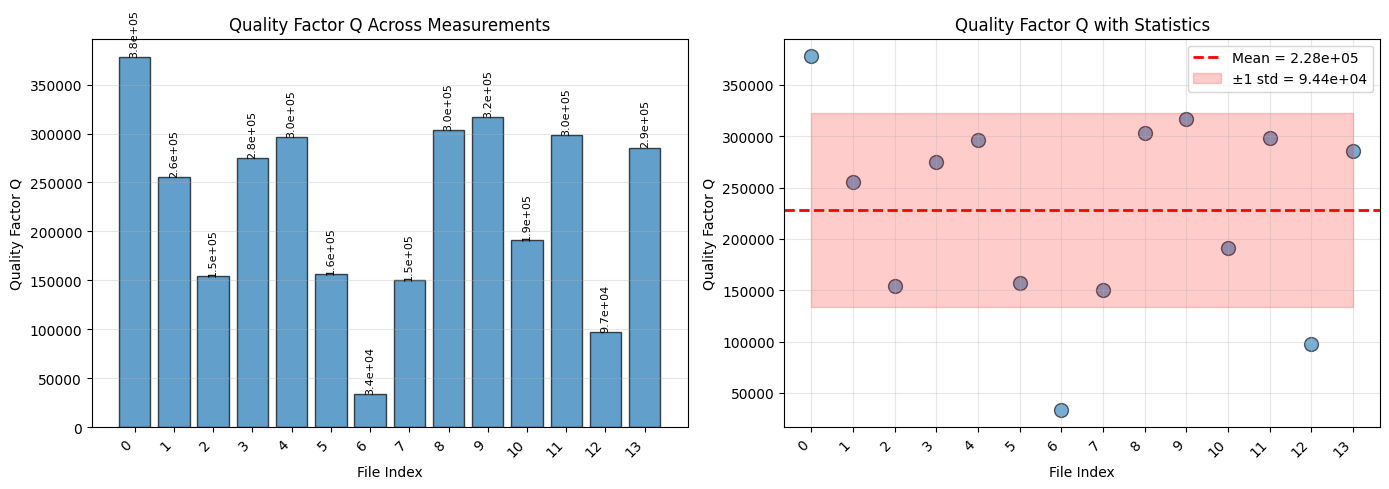


Q Factor Statistics:
  Mean Q: 2.28e+05
  Std Q: 9.44e+04
  Min Q: 3.36e+04
  Max Q: 3.78e+05
  Range: 3.44e+05


In [9]:
# Calculate Q factor for each result
# Q = pi * f * tau (from tau = Q/(pi*f))
for r in results:
    # Use NLS frequency estimate for Q calculation
    r['Q'] = np.pi * r['f_nls'] * r['tau_est']

# Plot Q factor across all measurements
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Extract Q values and filenames
Q_values = [r['Q'] for r in results]
filenames_short = [Path(r['filename']).stem[:30] for r in results]

# Plot 1: Q factor bar chart
ax = axes[0]
x_pos = np.arange(len(Q_values))
bars = ax.bar(x_pos, Q_values, alpha=0.7, edgecolor='black')
ax.set_xlabel('File Index')
ax.set_ylabel('Quality Factor Q')
ax.set_title('Quality Factor Q Across Measurements')
ax.set_xticks(x_pos)
ax.set_xticklabels([f'{i}' for i in range(len(Q_values))], rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, Q) in enumerate(zip(bars, Q_values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{Q:.1e}',
            ha='center', va='bottom', fontsize=8, rotation=90)

# Plot 2: Q factor scatter with statistics
ax = axes[1]
ax.scatter(x_pos, Q_values, s=100, alpha=0.6, edgecolors='black')
Q_mean = np.mean(Q_values)
Q_std = np.std(Q_values)
ax.axhline(Q_mean, color='r', linestyle='--', linewidth=2, 
           label=f'Mean = {Q_mean:.2e}')
ax.fill_between(x_pos, Q_mean - Q_std, Q_mean + Q_std, 
                alpha=0.2, color='r', label=f'±1 std = {Q_std:.2e}')
ax.set_xlabel('File Index')
ax.set_ylabel('Quality Factor Q')
ax.set_title('Quality Factor Q with Statistics')
ax.set_xticks(x_pos)
ax.set_xticklabels([f'{i}' for i in range(len(Q_values))], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print(f"\nQ Factor Statistics:")
print(f"  Mean Q: {Q_mean:.2e}")
print(f"  Std Q: {Q_std:.2e}")
print(f"  Min Q: {np.min(Q_values):.2e}")
print(f"  Max Q: {np.max(Q_values):.2e}")
print(f"  Range: {np.max(Q_values) - np.min(Q_values):.2e}")


## Comparison Plot

Compare the frequency estimates from both methods across all files.


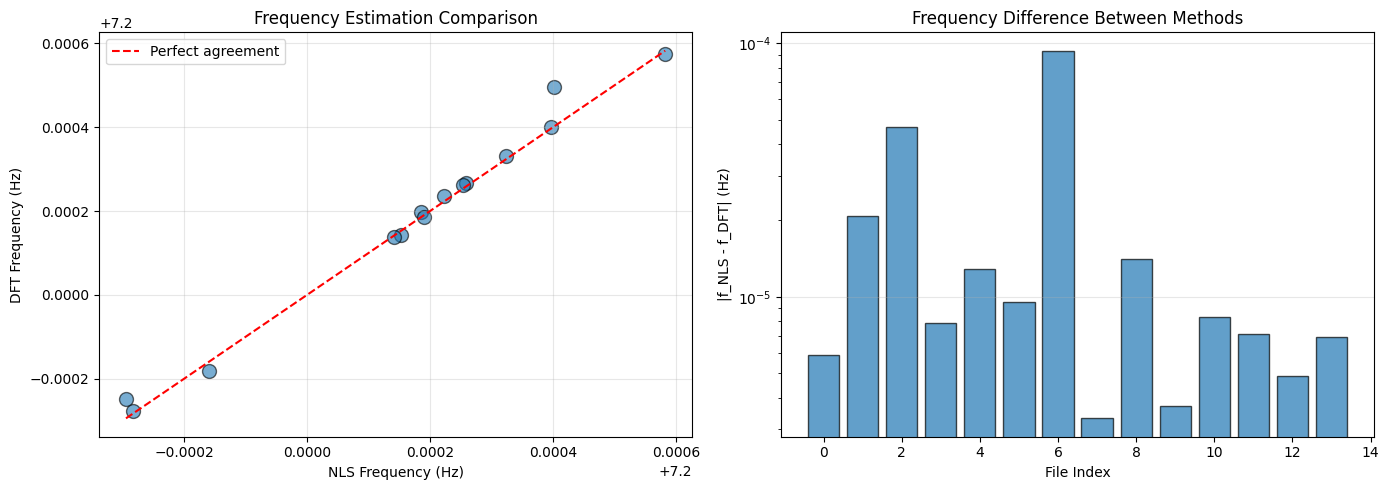


Mean absolute difference: 1.755301e-05 Hz
Max absolute difference: 9.338526e-05 Hz
Min absolute difference: 3.314721e-06 Hz


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Extract frequencies
f_nls_all = [r['f_nls'] for r in results]
f_dft_all = [r['f_dft'] for r in results]
filenames_short = [Path(r['filename']).stem[:30] for r in results]

# Plot 1: Scatter comparison
ax = axes[0]
ax.scatter(f_nls_all, f_dft_all, s=100, alpha=0.6, edgecolors='black')
# Add diagonal line
f_min = min(min(f_nls_all), min(f_dft_all))
f_max = max(max(f_nls_all), max(f_dft_all))
ax.plot([f_min, f_max], [f_min, f_max], 'r--', label='Perfect agreement')
ax.set_xlabel('NLS Frequency (Hz)')
ax.set_ylabel('DFT Frequency (Hz)')
ax.set_title('Frequency Estimation Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Difference histogram
ax = axes[1]
diffs = [abs(f_nls - f_dft) for f_nls, f_dft in zip(f_nls_all, f_dft_all)]
ax.bar(range(len(diffs)), diffs, alpha=0.7, edgecolor='black')
ax.set_xlabel('File Index')
ax.set_ylabel('|f_NLS - f_DFT| (Hz)')
ax.set_title('Frequency Difference Between Methods')
ax.set_yscale('log')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nMean absolute difference: {np.mean(diffs):.6e} Hz")
print(f"Max absolute difference: {np.max(diffs):.6e} Hz")
print(f"Min absolute difference: {np.min(diffs):.6e} Hz")


## CRLB Analysis

Compare the frequency estimation differences with the theoretical CRLB (Cramér-Rao Lower Bound).


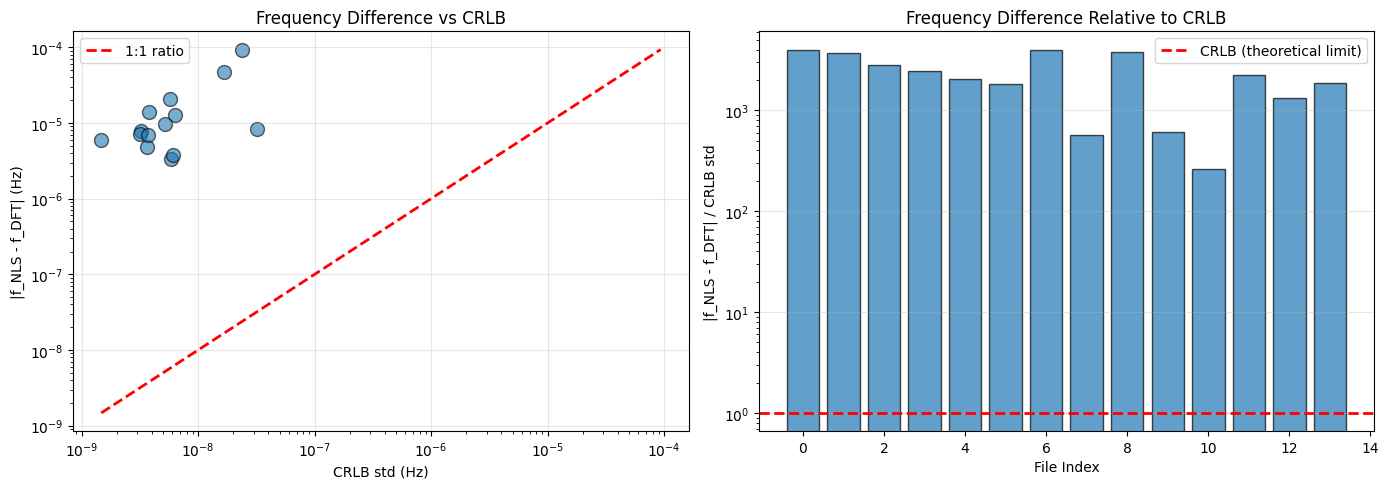


CRLB Statistics:
  Mean CRLB std: 8.613841e-09 Hz
  Min CRLB std: 1.472448e-09 Hz
  Max CRLB std: 3.193534e-08 Hz

Ratio Statistics (|Δf| / CRLB):
  Mean ratio: 2235.6886
  Median ratio: 2128.8851
  Max ratio: 4002.5057
  Min ratio: 260.5955

Note: Ratio < 1 means the difference is smaller than the theoretical limit (good!)
      Ratio > 1 means the difference exceeds the theoretical limit


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Extract data
diffs = [abs(r['f_nls'] - r['f_dft']) for r in results]
crlb_stds = [r['crlb_std_f'] for r in results]
filenames_short = [Path(r['filename']).stem[:30] for r in results]

# Plot 1: Frequency difference vs CRLB
ax = axes[0]
ax.scatter(crlb_stds, diffs, s=100, alpha=0.6, edgecolors='black')
# Add diagonal line (1:1 ratio)
max_val = max(max(crlb_stds), max(diffs))
min_val = min(min(crlb_stds), min(diffs))
ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='1:1 ratio', linewidth=2)
ax.set_xlabel('CRLB std (Hz)')
ax.set_ylabel('|f_NLS - f_DFT| (Hz)')
ax.set_title('Frequency Difference vs CRLB')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Ratio of difference to CRLB
ax = axes[1]
ratios = [d / crlb if crlb > 0 and np.isfinite(crlb) else np.nan 
          for d, crlb in zip(diffs, crlb_stds)]
valid_ratios = [r for r in ratios if not np.isnan(r)]
ax.bar(range(len(ratios)), ratios, alpha=0.7, edgecolor='black')
ax.axhline(1.0, color='r', linestyle='--', linewidth=2, label='CRLB (theoretical limit)')
ax.set_xlabel('File Index')
ax.set_ylabel('|f_NLS - f_DFT| / CRLB std')
ax.set_title('Frequency Difference Relative to CRLB')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nCRLB Statistics:")
print(f"  Mean CRLB std: {np.mean([c for c in crlb_stds if np.isfinite(c)]):.6e} Hz")
print(f"  Min CRLB std: {np.min([c for c in crlb_stds if np.isfinite(c)]):.6e} Hz")
print(f"  Max CRLB std: {np.max([c for c in crlb_stds if np.isfinite(c)]):.6e} Hz")
print(f"\nRatio Statistics (|Δf| / CRLB):")
print(f"  Mean ratio: {np.mean(valid_ratios):.4f}")
print(f"  Median ratio: {np.median(valid_ratios):.4f}")
print(f"  Max ratio: {np.max(valid_ratios):.4f}")
print(f"  Min ratio: {np.min(valid_ratios):.4f}")
print(f"\nNote: Ratio < 1 means the difference is smaller than the theoretical limit (good!)")
print(f"      Ratio > 1 means the difference exceeds the theoretical limit")


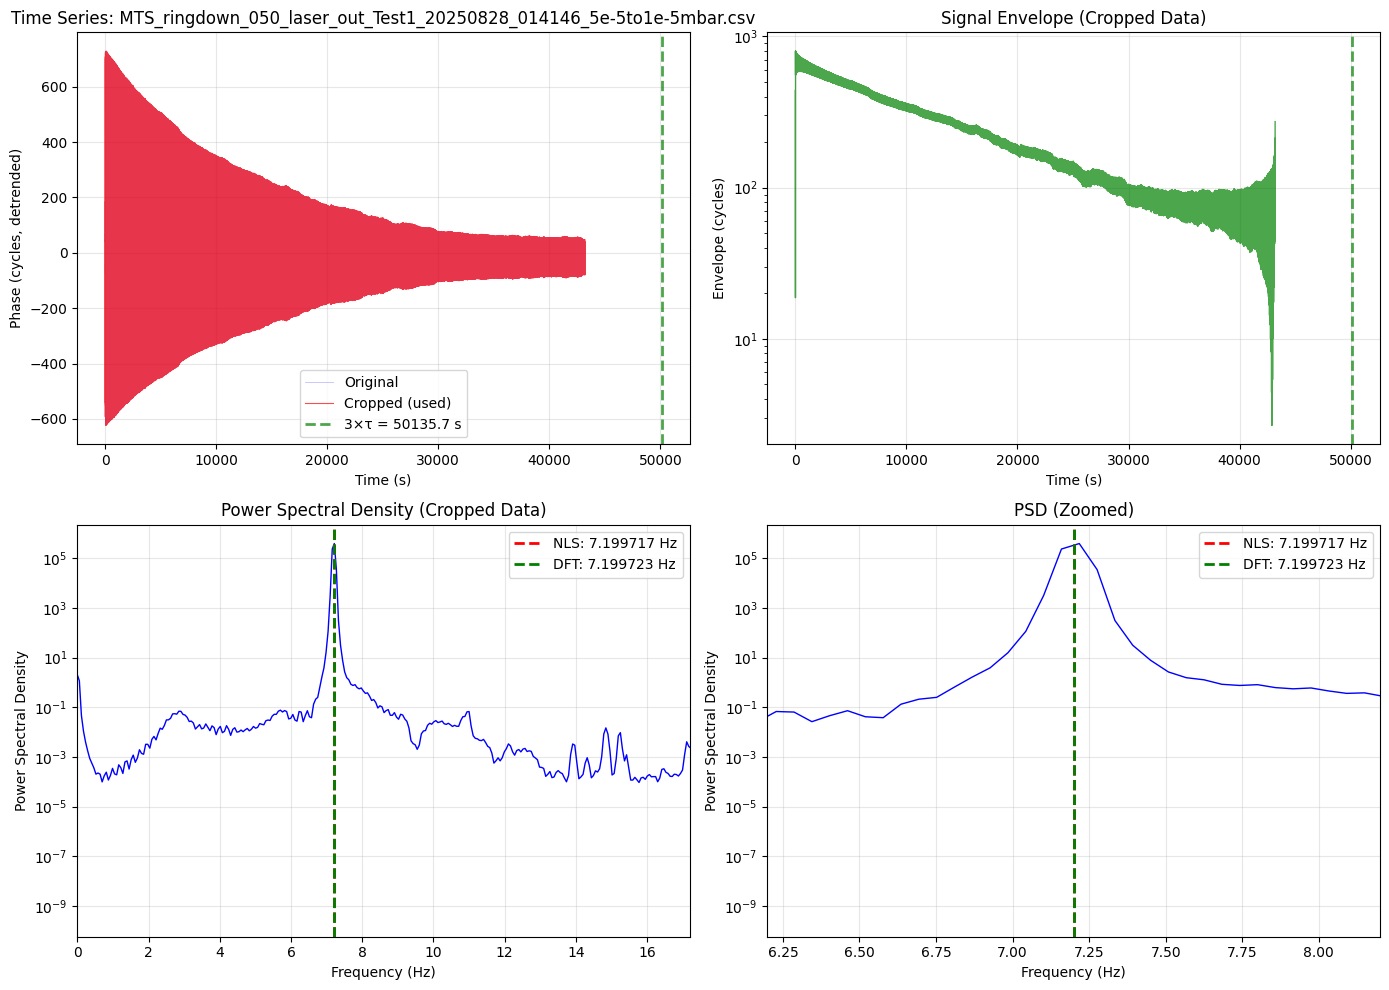


Detailed Analysis for: MTS_ringdown_050_laser_out_Test1_20250828_014146_5e-5to1e-5mbar.csv
  Sampling frequency: 476.837158 Hz
  Original number of samples: 20599366
  Cropped number of samples: 20599366 (100.0% of original)
  Original duration: 43200.00 s
  Cropped duration: 43200.00 s
  Estimated tau: 16711.90 s
  Crop limit (3×τ): 50135.70 s
  NLS frequency: 7.199717347923 Hz
  DFT frequency: 7.199723241403 Hz
  Difference: 5.893480004460e-06 Hz
  Relative difference: 0.8186 ppm
  CRLB std: 1.472447612635e-09 Hz
  A0 estimate: 583.333999
  Sigma (noise) estimate: 8.257399e+01


In [12]:
# Select first file for detailed analysis
if len(results) > 0:
    r = results[0]  # Change index to analyze different files
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    t = r['t']
    data = r['data']
    t_crop = r['t_crop']
    data_cropped = r['data_cropped']
    fs = r['fs']
    
    # Plot 1: Time series (original and cropped)
    ax = axes[0, 0]
    # Downsample for plotting
    step = max(1, len(t) // 50000)
    ax.plot(t[::step], data[::step], 'b-', alpha=0.3, linewidth=0.5, label='Original')
    step_crop = max(1, len(t_crop) // 50000)
    ax.plot(t_crop[::step_crop], data_cropped[::step_crop], 'r-', alpha=0.7, linewidth=0.8, label='Cropped (used)')
    # Add vertical line at 3*tau
    t_crop_max = 3.0 * r['tau_est']
    ax.axvline(t_crop_max, color='g', linestyle='--', linewidth=2, alpha=0.7, label=f'3×τ = {t_crop_max:.1f} s')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Phase (cycles, detrended)')
    ax.set_title(f"Time Series: {r['filename']}")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Envelope (cropped data)
    ax = axes[0, 1]
    from scipy.signal import hilbert
    analytic_signal = hilbert(data_cropped)
    envelope = np.abs(analytic_signal)
    ax.plot(t_crop[::step_crop], envelope[::step_crop], 'g-', alpha=0.7, linewidth=1)
    ax.axvline(t_crop_max, color='g', linestyle='--', linewidth=2, alpha=0.7)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Envelope (cycles)')
    ax.set_title('Signal Envelope (Cropped Data)')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Power Spectral Density (using cropped data)
    ax = axes[1, 0]
    # Compute PSD using Welch's method
    from scipy.signal import welch
    f_psd, Pxx = welch(data_cropped, fs, nperseg=min(8192, len(data_cropped)//4))
    ax.semilogy(f_psd, Pxx, 'b-', linewidth=1)
    ax.axvline(r['f_nls'], color='r', linestyle='--', linewidth=2, label=f"NLS: {r['f_nls']:.6f} Hz")
    ax.axvline(r['f_dft'], color='g', linestyle='--', linewidth=2, label=f"DFT: {r['f_dft']:.6f} Hz")
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power Spectral Density')
    ax.set_title('Power Spectral Density (Cropped Data)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    # Zoom around estimated frequencies
    f_center = (r['f_nls'] + r['f_dft']) / 2
    f_range = max(abs(r['f_nls'] - r['f_dft']) * 10, 10.0)
    ax.set_xlim([max(0, f_center - f_range), f_center + f_range])
    
    # Plot 4: Zoomed PSD around peak
    ax = axes[1, 1]
    ax.semilogy(f_psd, Pxx, 'b-', linewidth=1)
    ax.axvline(r['f_nls'], color='r', linestyle='--', linewidth=2, label=f"NLS: {r['f_nls']:.6f} Hz")
    ax.axvline(r['f_dft'], color='g', linestyle='--', linewidth=2, label=f"DFT: {r['f_dft']:.6f} Hz")
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power Spectral Density')
    ax.set_title('PSD (Zoomed)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    # Zoom
    f_range = max(abs(r['f_nls'] - r['f_dft']) * 10, 1.0)
    ax.set_xlim([max(0, f_center - f_range), f_center + f_range])
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nDetailed Analysis for: {r['filename']}")
    print(f"  Sampling frequency: {fs:.6f} Hz")
    print(f"  Original number of samples: {r['N']}")
    print(f"  Cropped number of samples: {r['N_crop']} ({r['N_crop']/r['N']*100:.1f}% of original)")
    print(f"  Original duration: {r['T']:.2f} s")
    print(f"  Cropped duration: {r['T_crop']:.2f} s")
    print(f"  Estimated tau: {r['tau_est']:.2f} s")
    print(f"  Crop limit (3×τ): {3.0*r['tau_est']:.2f} s")
    print(f"  NLS frequency: {r['f_nls']:.12f} Hz")
    print(f"  DFT frequency: {r['f_dft']:.12f} Hz")
    print(f"  Difference: {abs(r['f_nls'] - r['f_dft']):.12e} Hz")
    print(f"  Relative difference: {abs(r['f_nls'] - r['f_dft']) / r['f_nls'] * 1e6:.4f} ppm")
    print(f"  CRLB std: {r['crlb_std_f']:.12e} Hz")
    print(f"  A0 estimate: {r['A0_est']:.6f}")
    print(f"  Sigma (noise) estimate: {r['sigma_est']:.6e}")


## Consistency Analysis Across Realizations

In addition to comparing NLS vs DFT and both against CRLB, we also want to assess the consistency of each method across different experimental realizations (different measurement files). This helps us understand:

1. **NLS consistency**: How much do NLS frequency estimates vary across different realizations?

2. **DFT consistency**: How much do DFT frequency estimates vary across different realizations?

We'll compute pairwise differences between all realizations for each method and visualize the results.


In [13]:
# Extract frequencies for all realizations
f_nls_all = np.array([r['f_nls'] for r in results])
f_dft_all = np.array([r['f_dft'] for r in results])
filenames = [r['filename'] for r in results]
n_realizations = len(results)

# Compute pairwise differences for NLS
nls_pairwise_diffs = []
nls_pairwise_indices = []
for i in range(n_realizations):
    for j in range(i + 1, n_realizations):
        diff = abs(f_nls_all[i] - f_nls_all[j])
        nls_pairwise_diffs.append(diff)
        nls_pairwise_indices.append((i, j))

# Compute pairwise differences for DFT
dft_pairwise_diffs = []
dft_pairwise_indices = []
for i in range(n_realizations):
    for j in range(i + 1, n_realizations):
        diff = abs(f_dft_all[i] - f_dft_all[j])
        dft_pairwise_diffs.append(diff)
        dft_pairwise_indices.append((i, j))

nls_pairwise_diffs = np.array(nls_pairwise_diffs)
dft_pairwise_diffs = np.array(dft_pairwise_diffs)

print(f"Number of realizations: {n_realizations}")
print(f"Number of pairwise comparisons: {len(nls_pairwise_diffs)}")
print(f"\nNLS pairwise differences:")
print(f"  Mean: {np.mean(nls_pairwise_diffs):.6e} Hz")
print(f"  Median: {np.median(nls_pairwise_diffs):.6e} Hz")
print(f"  Std: {np.std(nls_pairwise_diffs):.6e} Hz")
print(f"  Min: {np.min(nls_pairwise_diffs):.6e} Hz")
print(f"  Max: {np.max(nls_pairwise_diffs):.6e} Hz")
print(f"\nDFT pairwise differences:")
print(f"  Mean: {np.mean(dft_pairwise_diffs):.6e} Hz")
print(f"  Median: {np.median(dft_pairwise_diffs):.6e} Hz")
print(f"  Std: {np.std(dft_pairwise_diffs):.6e} Hz")
print(f"  Min: {np.min(dft_pairwise_diffs):.6e} Hz")
print(f"  Max: {np.max(dft_pairwise_diffs):.6e} Hz")


Number of realizations: 14
Number of pairwise comparisons: 91

NLS pairwise differences:
  Mean: 2.855650e-04 Hz
  Median: 2.169263e-04 Hz
  Std: 2.210848e-04 Hz
  Min: 5.089798e-06 Hz
  Max: 8.770185e-04 Hz

DFT pairwise differences:
  Mean: 2.933352e-04 Hz
  Median: 2.591878e-04 Hz
  Std: 2.179842e-04 Hz
  Min: 4.675297e-06 Hz
  Max: 8.511664e-04 Hz


/var/folders/z2/0sr40kf12437n7qv4v0qb7gm0000gn/T/ipykernel_22976/3469118193.py:50: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=['NLS', 'DFT'], patch_artist=True)


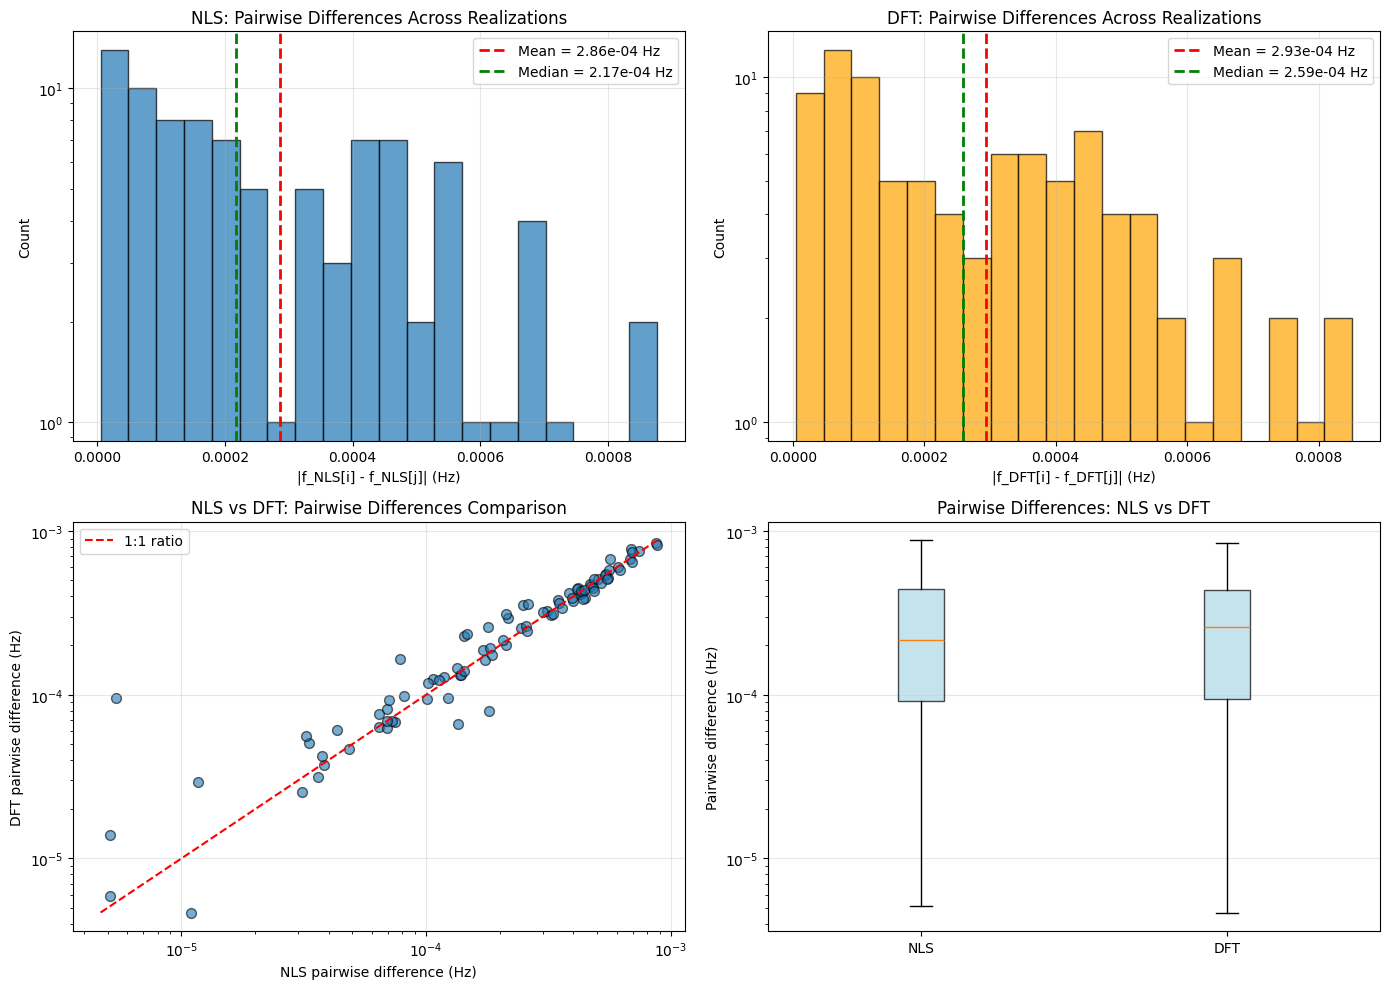

In [14]:
# Visualize pairwise differences
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Histogram of NLS pairwise differences
ax = axes[0, 0]
ax.hist(nls_pairwise_diffs, bins=20, alpha=0.7, edgecolor='black')
ax.set_xlabel('|f_NLS[i] - f_NLS[j]| (Hz)')
ax.set_ylabel('Count')
ax.set_title('NLS: Pairwise Differences Across Realizations')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)
ax.axvline(np.mean(nls_pairwise_diffs), color='r', linestyle='--', linewidth=2, 
           label=f'Mean = {np.mean(nls_pairwise_diffs):.2e} Hz')
ax.axvline(np.median(nls_pairwise_diffs), color='g', linestyle='--', linewidth=2,
           label=f'Median = {np.median(nls_pairwise_diffs):.2e} Hz')
ax.legend()

# Plot 2: Histogram of DFT pairwise differences
ax = axes[0, 1]
ax.hist(dft_pairwise_diffs, bins=20, alpha=0.7, edgecolor='black', color='orange')
ax.set_xlabel('|f_DFT[i] - f_DFT[j]| (Hz)')
ax.set_ylabel('Count')
ax.set_title('DFT: Pairwise Differences Across Realizations')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)
ax.axvline(np.mean(dft_pairwise_diffs), color='r', linestyle='--', linewidth=2,
           label=f'Mean = {np.mean(dft_pairwise_diffs):.2e} Hz')
ax.axvline(np.median(dft_pairwise_diffs), color='g', linestyle='--', linewidth=2,
           label=f'Median = {np.median(dft_pairwise_diffs):.2e} Hz')
ax.legend()

# Plot 3: Comparison of NLS vs DFT pairwise differences
ax = axes[1, 0]
ax.scatter(nls_pairwise_diffs, dft_pairwise_diffs, alpha=0.6, s=50, edgecolors='black')
# Add diagonal line
max_val = max(np.max(nls_pairwise_diffs), np.max(dft_pairwise_diffs))
min_val = min(np.min(nls_pairwise_diffs), np.min(dft_pairwise_diffs))
ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='1:1 ratio')
ax.set_xlabel('NLS pairwise difference (Hz)')
ax.set_ylabel('DFT pairwise difference (Hz)')
ax.set_title('NLS vs DFT: Pairwise Differences Comparison')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Box plot comparison
ax = axes[1, 1]
data = [nls_pairwise_diffs, dft_pairwise_diffs]
bp = ax.boxplot(data, labels=['NLS', 'DFT'], patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_alpha(0.7)
ax.set_ylabel('Pairwise difference (Hz)')
ax.set_title('Pairwise Differences: NLS vs DFT')
ax.set_yscale('log')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


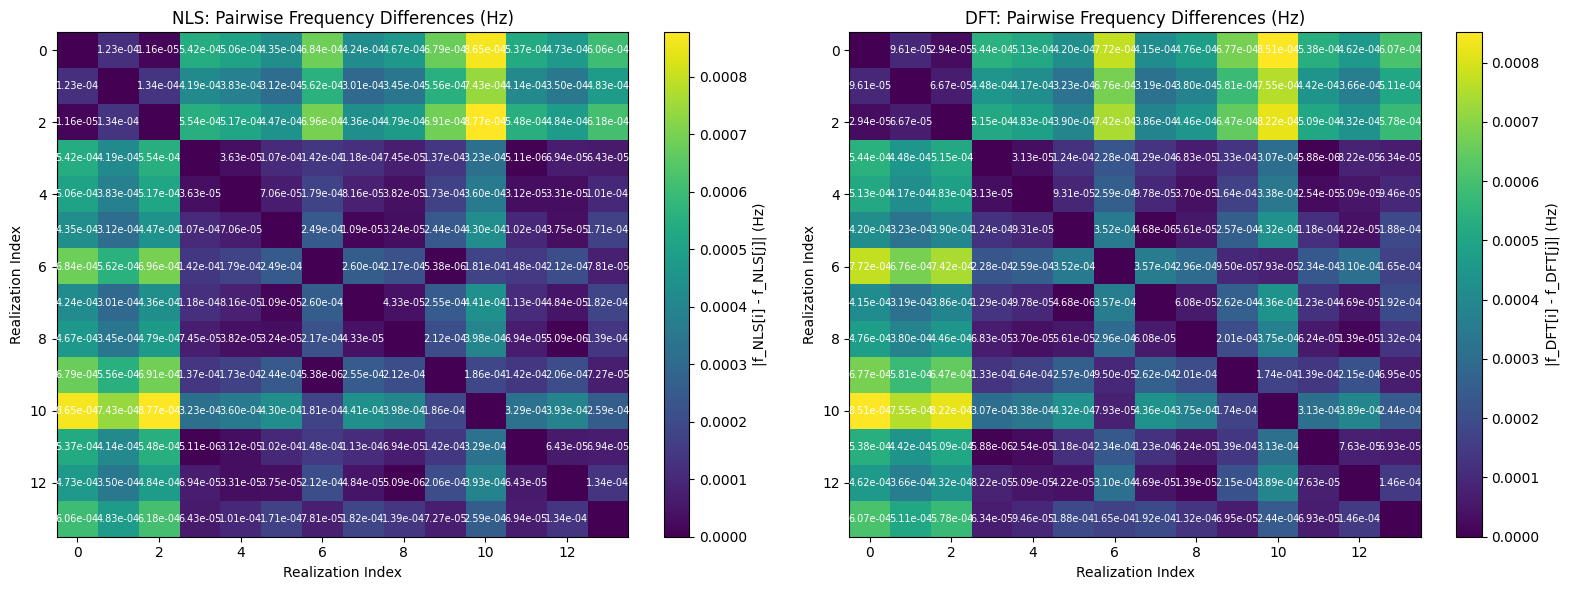

In [15]:
# Create a matrix visualization of pairwise differences
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# NLS pairwise difference matrix
ax = axes[0]
nls_matrix = np.zeros((n_realizations, n_realizations))
for idx, (i, j) in enumerate(nls_pairwise_indices):
    diff = nls_pairwise_diffs[idx]
    nls_matrix[i, j] = diff
    nls_matrix[j, i] = diff  # Make symmetric

im1 = ax.imshow(nls_matrix, cmap='viridis', aspect='auto', origin='upper')
ax.set_title('NLS: Pairwise Frequency Differences (Hz)')
ax.set_xlabel('Realization Index')
ax.set_ylabel('Realization Index')
plt.colorbar(im1, ax=ax, label='|f_NLS[i] - f_NLS[j]| (Hz)')

# Add text annotations for small matrices
if n_realizations <= 15:
    for i in range(n_realizations):
        for j in range(n_realizations):
            if i != j:
                text = ax.text(j, i, f'{nls_matrix[i, j]:.2e}',
                             ha="center", va="center", color="white", fontsize=7)

# DFT pairwise difference matrix
ax = axes[1]
dft_matrix = np.zeros((n_realizations, n_realizations))
for idx, (i, j) in enumerate(dft_pairwise_indices):
    diff = dft_pairwise_diffs[idx]
    dft_matrix[i, j] = diff
    dft_matrix[j, i] = diff  # Make symmetric

im2 = ax.imshow(dft_matrix, cmap='viridis', aspect='auto', origin='upper')
ax.set_title('DFT: Pairwise Frequency Differences (Hz)')
ax.set_xlabel('Realization Index')
ax.set_ylabel('Realization Index')
plt.colorbar(im2, ax=ax, label='|f_DFT[i] - f_DFT[j]| (Hz)')

# Add text annotations for small matrices
if n_realizations <= 15:
    for i in range(n_realizations):
        for j in range(n_realizations):
            if i != j:
                text = ax.text(j, i, f'{dft_matrix[i, j]:.2e}',
                             ha="center", va="center", color="white", fontsize=7)

plt.tight_layout()
plt.show()


In [16]:
# Calculate overall statistics for consistency
# Compute standard deviation across all realizations for each method
nls_std_across_realizations = np.std(f_nls_all)
dft_std_across_realizations = np.std(f_dft_all)

# Compute mean frequency for each method
nls_mean = np.mean(f_nls_all)
dft_mean = np.mean(f_dft_all)

# Compute coefficient of variation (relative standard deviation)
nls_cv = nls_std_across_realizations / nls_mean if nls_mean > 0 else np.inf
dft_cv = dft_std_across_realizations / dft_mean if dft_mean > 0 else np.inf

print("=" * 70)
print("Consistency Analysis Summary")
print("=" * 70)
print(f"\nNLS Method:")
print(f"  Mean frequency across realizations: {nls_mean:.9f} Hz")
print(f"  Std across realizations: {nls_std_across_realizations:.6e} Hz")
print(f"  Coefficient of variation: {nls_cv:.2e}")
print(f"  Range: [{np.min(f_nls_all):.9f}, {np.max(f_nls_all):.9f}] Hz")
print(f"  Span: {np.max(f_nls_all) - np.min(f_nls_all):.6e} Hz")

print(f"\nDFT Method:")
print(f"  Mean frequency across realizations: {dft_mean:.9f} Hz")
print(f"  Std across realizations: {dft_std_across_realizations:.6e} Hz")
print(f"  Coefficient of variation: {dft_cv:.2e}")
print(f"  Range: [{np.min(f_dft_all):.9f}, {np.max(f_dft_all):.9f}] Hz")
print(f"  Span: {np.max(f_dft_all) - np.min(f_dft_all):.6e} Hz")

print(f"\nComparison:")
print(f"  NLS span / DFT span: {(np.max(f_nls_all) - np.min(f_nls_all)) / (np.max(f_dft_all) - np.min(f_dft_all)):.4f}")
print(f"  NLS std / DFT std: {nls_std_across_realizations / dft_std_across_realizations:.4f}")

# Compare with CRLB
mean_crlb = np.mean([r['crlb_std_f'] for r in results if np.isfinite(r['crlb_std_f'])])
print(f"\nCRLB reference:")
print(f"  Mean CRLB std: {mean_crlb:.6e} Hz")
print(f"  NLS std / mean CRLB: {nls_std_across_realizations / mean_crlb:.2f}")
print(f"  DFT std / mean CRLB: {dft_std_across_realizations / mean_crlb:.2f}")


Consistency Analysis Summary

NLS Method:
  Mean frequency across realizations: 7.200169493 Hz
  Std across realizations: 2.460790e-04 Hz
  Coefficient of variation: 3.42e-05
  Range: [7.199705711, 7.200582730] Hz
  Span: 8.770185e-04 Hz

DFT Method:
  Mean frequency across realizations: 7.200180354 Hz
  Std across realizations: 2.490206e-04 Hz
  Coefficient of variation: 3.46e-05
  Range: [7.199723241, 7.200574408] Hz
  Span: 8.511664e-04 Hz

Comparison:
  NLS span / DFT span: 1.0304
  NLS std / DFT std: 0.9882

CRLB reference:
  Mean CRLB std: 8.613841e-09 Hz
  NLS std / mean CRLB: 28567.86
  DFT std / mean CRLB: 28909.35


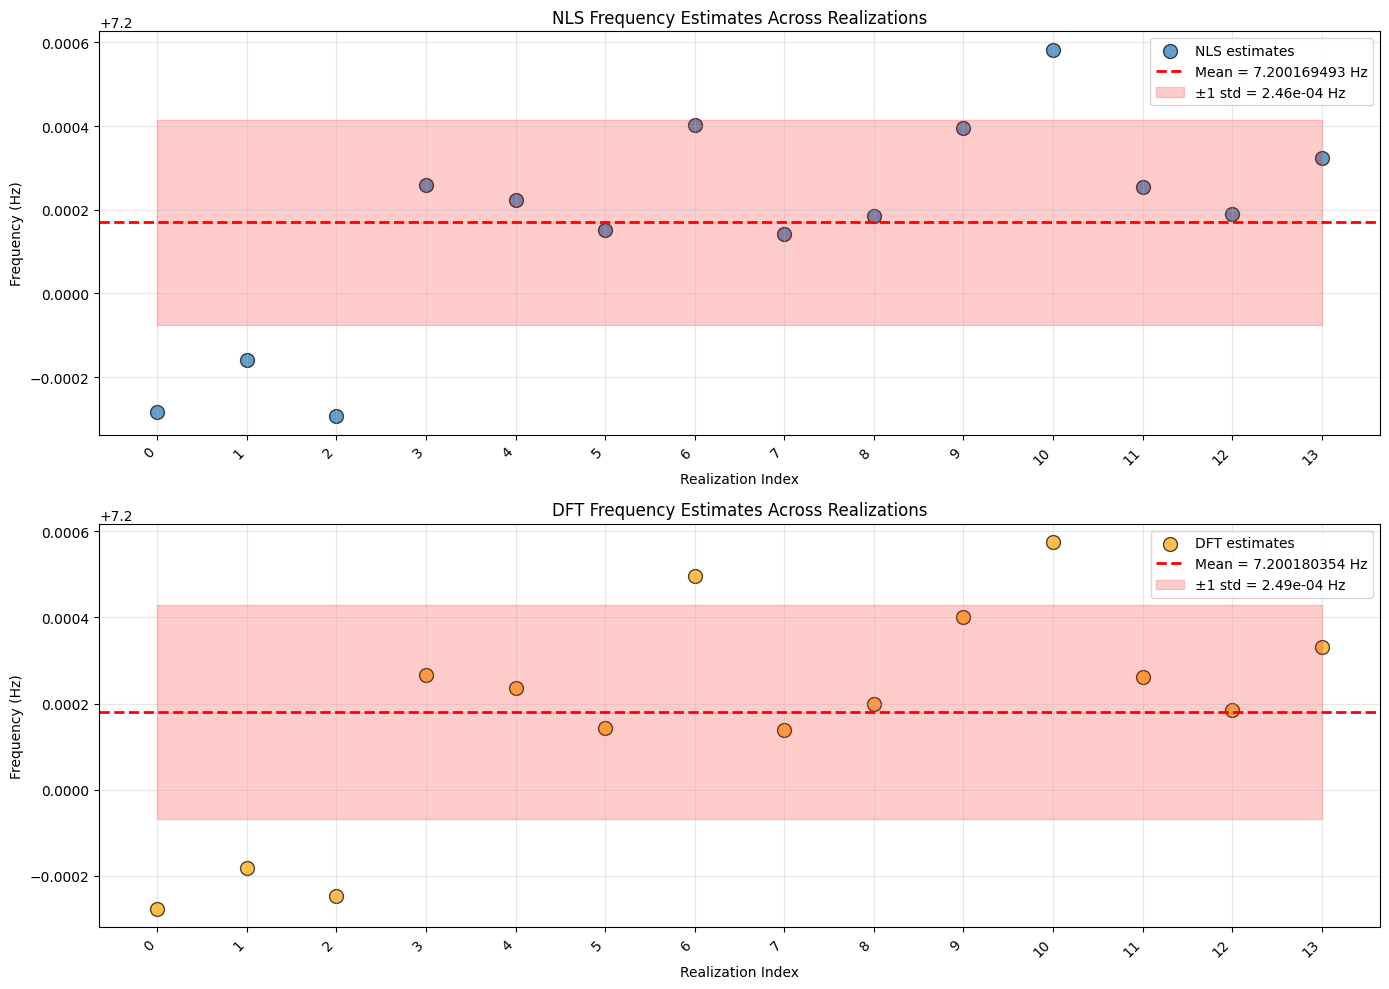

In [17]:
# Visualize frequency estimates across realizations
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: NLS frequencies across realizations
ax = axes[0]
x_pos = np.arange(n_realizations)
ax.scatter(x_pos, f_nls_all, s=100, alpha=0.7, edgecolors='black', label='NLS estimates')
ax.axhline(nls_mean, color='r', linestyle='--', linewidth=2, label=f'Mean = {nls_mean:.9f} Hz')
ax.fill_between(x_pos, nls_mean - nls_std_across_realizations, 
                nls_mean + nls_std_across_realizations, 
                alpha=0.2, color='r', label=f'±1 std = {nls_std_across_realizations:.2e} Hz')
ax.set_xlabel('Realization Index')
ax.set_ylabel('Frequency (Hz)')
ax.set_title('NLS Frequency Estimates Across Realizations')
ax.set_xticks(x_pos)
ax.set_xticklabels([f'{i}' for i in range(n_realizations)], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: DFT frequencies across realizations
ax = axes[1]
ax.scatter(x_pos, f_dft_all, s=100, alpha=0.7, edgecolors='black', color='orange', label='DFT estimates')
ax.axhline(dft_mean, color='r', linestyle='--', linewidth=2, label=f'Mean = {dft_mean:.9f} Hz')
ax.fill_between(x_pos, dft_mean - dft_std_across_realizations, 
                dft_mean + dft_std_across_realizations, 
                alpha=0.2, color='r', label=f'±1 std = {dft_std_across_realizations:.2e} Hz')
ax.set_xlabel('Realization Index')
ax.set_ylabel('Frequency (Hz)')
ax.set_title('DFT Frequency Estimates Across Realizations')
ax.set_xticks(x_pos)
ax.set_xticklabels([f'{i}' for i in range(n_realizations)], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [18]:
# Create a table showing all frequency estimates
import pandas as pd

consistency_data = []
for i, r in enumerate(results):
    consistency_data.append({
        'Index': i,
        'Filename': Path(r['filename']).name[:40],
        'f_NLS (Hz)': f"{r['f_nls']:.9f}",
        'f_DFT (Hz)': f"{r['f_dft']:.9f}",
        'Deviation from NLS mean (Hz)': f"{(r['f_nls'] - nls_mean):.6e}",
        'Deviation from DFT mean (Hz)': f"{(r['f_dft'] - dft_mean):.6e}",
        'CRLB std (Hz)': f"{r['crlb_std_f']:.6e}",
    })

df_consistency = pd.DataFrame(consistency_data)
print("Frequency Estimates and Deviations from Mean:")
print("=" * 120)
print(df_consistency.to_string(index=False))


Frequency Estimates and Deviations from Mean:
 Index                                 Filename  f_NLS (Hz)  f_DFT (Hz) Deviation from NLS mean (Hz) Deviation from DFT mean (Hz) CRLB std (Hz)
     0 MTS_ringdown_050_laser_out_Test1_2025082 7.199717348 7.199723241                -4.521450e-04                -4.571123e-04  1.472448e-09
     1 MTS_ringdown_050_laser_out_Test2_2025082 7.199840162 7.199819379                -3.293309e-04                -3.609743e-04  5.683674e-09
     2 MTS_ringdown_050_laser_out_Test5_2025090 7.199705711 7.199752632                -4.637814e-04                -4.277217e-04  1.668195e-08
     3 MTSRingdownEighthAttempt_20250904_111201 7.200259322 7.200267211                 8.982906e-05                 8.685683e-05  3.248336e-09
     4 MTSRingdownEleventhAttempt_20250907_1655 7.200223045 7.200235943                 5.355238e-05                 5.558906e-05  6.362574e-09
     5 MTSRingdownFifthAttempt_20250828_132020  7.200152402 7.200142850                -1.